# Word2Vecを利用したレコメンドロジック
#### 参考サイト：https://yolo-kiyoshi.com/2019/10/31/post-1324/

## ライブラリーインポート

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## データインポート

In [2]:
apps = pd.read_table('data/apps.tsv')

In [3]:
type(apps.ApplicationDate[0])

str

In [4]:
# tsvファイルの読み込み
apps = pd.read_table('data/apps.tsv')
# ApplicationDateをtimestampにパース
apps.loc[:, 'ApplicationDate'] = pd.to_datetime(apps.ApplicationDate).dt.date

print(f'ユニークユーザ数：{len(set(apps.UserID))}')
print(f'ユニークJobID数：{len(set(apps.JobID))}')
print(f'応募日from：{apps.ApplicationDate.min()}')
print(f'応募日to：{apps.ApplicationDate.max()}')

ユニークユーザ数：321235
ユニークJobID数：365668
応募日from：2012-04-01
応募日to：2012-06-26


In [5]:
apps

,UserID,WindowID,Split,ApplicationDate,JobID
0,47,1,Train,2012-04-04,169528
1,47,1,Train,2012-04-06,284009
2,47,1,Train,2012-04-05,2121
3,47,1,Train,2012-04-05,848187
4,47,1,Train,2012-04-05,733748
...,...,...,...,...,...
1603106,1472089,7,Train,2012-06-23,573732
1603107,1472089,7,Train,2012-06-25,39401
1603108,1472089,7,Train,2012-04-30,175198
1603109,1472089,7,Train,2012-04-30,1073263


## JobIDを文字型に変更

In [11]:
apps.dtypes

UserID              int64
WindowID            int64
Split              object
ApplicationDate    object
JobID               int64
dtype: object

In [29]:
apps = apps.astype({'JobID':str, 'UserID':str})
apps.dtypes

UserID             object
WindowID            int64
Split              object
ApplicationDate    object
JobID              object
dtype: object

## 前処理

In [30]:
# 応募日ごとに昇順ソート
apps.sort_values(['UserID', 'ApplicationDate'], inplace=True)
apps

,UserID,WindowID,Split,ApplicationDate,JobID
225229,1000000,1,Train,2012-04-02,190785
225230,1000002,1,Train,2012-04-09,747094
225231,1000002,1,Train,2012-04-09,373607
225232,1000002,1,Train,2012-04-09,298065
225233,1000002,1,Train,2012-04-09,758045
...,...,...,...,...,...
703704,999979,3,Train,2012-05-16,928229
703705,999979,3,Train,2012-05-16,563986
703706,999981,3,Train,2012-05-04,38978
225227,999982,1,Train,2012-04-05,1065301


## 学習データとテストデータに分割
- 学習データ：2012-4-1 to 2012-6-20
- テストデータ：2012-6-21 to 2012-6-28

In [31]:
# 学習データとテストデータの分割
kijunbi = datetime.date(2012,6,21)
apps_train = apps.query('ApplicationDate < @kijunbi')
apps_test = apps.query('ApplicationDate >= @kijunbi')

##### ここで、Word2Vecに入力するデータは、ユーザ単位でJobIDがlistになっている必要があります。また、Word2Vecの学習データはJobIDのみで構成されていてUserIDの情報がないので、推論（most_similar）時に各レコメンド結果をUserIDと紐づけるためにも辞書を作成しておく必要があります。

In [32]:
# UserIDごとに応募日時の昇順で求人IDをリスト化
apps_train_w2v = []
apps_train_w2v_dict = {}
for i, v in apps_train.groupby(['UserID']):
    # 学習データ
    apps_train_w2v.append(list(v.JobID))
    # ユーザIDをKeyに持つ辞書
    apps_train_w2v_dict[i] = list(v.JobID)

## レコメンドモデルの構築

In [33]:
import turicreate as tc
# pandas.DataFrameをTuri Create独自のSFrameに変換
train = tc.SFrame(apps_train)
test = tc.SFrame(apps_test)
# 協調フィルタリングでモデル構築
model_cf = tc.recommender.create(train, user_id='UserID', item_id='JobID')

Warning: Ignoring columns WindowID, Split, ApplicationDate;

To use one of these as a rating column, specify the column name to be used as target

and use a method that allows the use of a target.

Preparing data set.

Data has 1514294 observations with 304823 users and 355535 items.

Data prepared in: 0.830572s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 630us                          | 0.25       |

| 36.482ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using sparse lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 401.62ms                            | 0                | 0               |

| 2.75s                               | 100              | 355535          |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.85722s

In [34]:
from gensim.models import word2vec

# ハイパーパラメータはデフォルト
model_w2v = word2vec.Word2Vec(apps_train_w2v, min_count=1)

## 推論

##### 今回は、学習データとテストデータに共通して存在しているユーザを対象にレコメンドし、その結果を評価します。まずは、学習データとテストデータに共通して存在しているユーザを抽出します。

In [35]:
# テストデータと学習データに共通するユーザIDの集合
train_test_UserID_set = set(apps_test.UserID).intersection(set(apps_train.UserID))
print(f'学習データとテストデータに共通するユーザ数：{len(train_test_UserID_set)}')

# レコメンド対象のユーザをlist化
recommend_user = list(train_test_UserID_set)

学習データとテストデータに共通するユーザ数：13485


##### アイテムベース協調フィルタリングの場合とは異なり、Word2Vecのmost_similar結果には学習時に使用したアイテム(つまり過去に応募したJobID)が含まれてしまう場合があるため、やや工夫が必要です。応募済みのJobIDをレコメンドしないために、各ユーザに対して以下の工程を行います。

1. ユーザが応募したJobIDベクトルを全て合成し、類似度上位100件を取得
2. 類似度上位100件の中で過去に応募したJobIDがあれば削除

##### ここで、アイテムベース協調フィルタリングと同じ30件ではなく100件を抽出している理由は、応募したJobIDを削除した後でもJobIDが30件以上必ず残したいためであり、なんとなく100件に指定しているだけです。

In [36]:
# 協調フィルタリングによるレコメンド
rec = model_cf.recommend(users=recommend_user, k=30, verbose=False)
rec = pd.DataFrame(rec)

In [37]:
jo_list = []
user_list = []
# レコメンド対象のユーザごとに処理
for user_id in recommend_user:
    # 学習データにおけるユーザの全ての行動履歴を合成しベクトル生成。
    # most_similarityはそのベクトルと類似した100件のJobIDを類似度とともにtupleで返却する。
    sim_list = model_w2v.wv.most_similar(positive=apps_train_w2v_dict[user_id], topn=100)

    jo_list_by_user = []
    # most_similarされたJobIDに応募済のものがある場合、レコメンド結果から除外
    for sim in sim_list:
        if sim[0] not in apps_train_w2v_dict[user_id]:
            jo_list_by_user.append(sim[0])

    jo_list.extend(jo_list_by_user)
    user_list.extend([user_id]*len(jo_list_by_user))

# 推論結果
rec_w2v = pd.concat(
    [
        pd.DataFrame(user_list, columns=['UserID']),
        pd.DataFrame(jo_list, columns=['JobID'])
    ],
    axis=1,
)

## レコメンド結果のオフライン評価

###### PrecisionとRecallを測定する関数を定義

In [38]:
import random

def evaluate_rec(
    recommend_user: list,
    apps_test: pd.DataFrame,
    rec: pd.DataFrame,
    topN: int
) -> (list, list):
    """'''
    レコメンド結果と実際の行動結果をもとにPresicion@K, Recall@Kを返却するメソッド。

    Parameters
    -------
    recommend_user : list
        レコメンド対象のUserIDのlist。
    apps_test : pd.DataFrame
        実際のユーザの行動履歴。UserID, JobIDをカラムに持つこと。
    rec : pd.DataFrame
        レコメンド結果。UserID, JobIDをカラムに持つこと。
    topN: int
        レコメンド結果の上位何件を評価対象とするか。

    Returns
    -------
    (recall, precision) : tuple
        Recall@KとPrecision@K。
    """

    precision = []
    recall = []

    for user_id in random.sample(recommend_user, 1000):
        result_set = set(apps_test.query(f'UserID == "{user_id}"').JobID)
        result_size = len(apps_test.query(f'UserID == "{user_id}"').JobID)

        rec_set = set(rec.query(f'UserID == "{user_id}"').JobID[:topN])
        try:
            # Recall@K
            recall.append(len(result_set.intersection(rec_set))/len(result_set))
            # Precisionl@K
            precision.append(len(rec_set.intersection(result_set))/len(rec_set))
        except ZeroDivisionError as e:
            print(e)
            print(f"UserID:{user_id} wasn't recommended.")

    return (recall, precision)

####  レコメンド評価

/Users/maeda/opt/anaconda3/envs/env1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/maeda/opt/anaconda3/envs/env1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/maeda/opt/anaconda3/envs/env1/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

Text(0.5, 1.0, 'Recall@30 of Word2Vec')

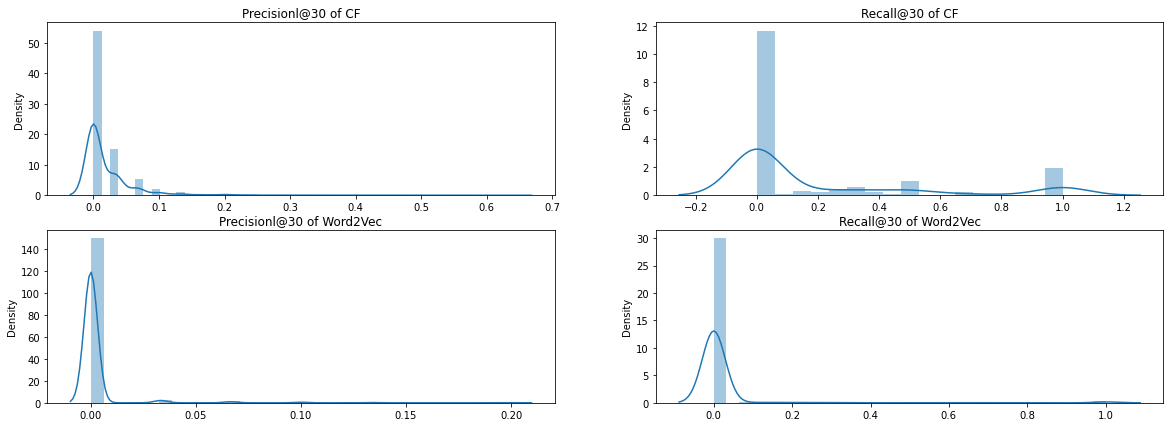

In [39]:
topN=30

# 協調フィルタリングの評価
recall, precision = evaluate_rec(recommend_user, apps_test, rec, topN=30)
# Word2Vecの評価
recall_w2v, precision_w2v = evaluate_rec(recommend_user, apps_test, rec_w2v, topN=30)

plt.figure(figsize=(20,7))
plt.subplot(2,2,1)
sns.distplot(precision)
plt.title(f'Precisionl@{topN} of CF')
plt.subplot(2,2,2)
sns.distplot(recall)
plt.title(f'Recall@{topN} of CF')

plt.subplot(2,2,3)
sns.distplot(precision_w2v)
plt.title(f'Precisionl@{topN} of Word2Vec')
plt.subplot(2,2,4)
sns.distplot(recall_w2v)
plt.title(f'Recall@{topN} of Word2Vec')

In [40]:
# 学習で用いられたJobIDの集合
train_job_set = set(apps_train.JobID)

# 協調フィルタリングでレコメンドされたJobIDの集合
rec_job_set = set(rec.JobID)

# Word2VecでレコメンドされたJobIDの集合
rec_job_w2v_set = set(rec_w2v.JobID)

coverage of CF : 0.15629966107415585
coverage of Word2Vec : 0.9642848102155905


<BarContainer object of 2 artists>

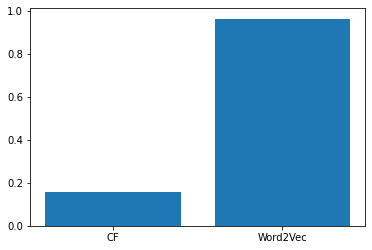

In [41]:
# カバレッジ
coverage = len(train_job_set.intersection(rec_job_set))/len(train_job_set)
coverage_w2v = len(train_job_set.intersection(rec_job_w2v_set))/len(train_job_set)
print(f'coverage of CF : {coverage}')
print(f'coverage of Word2Vec : {coverage_w2v}')

plt.bar(['CF', 'Word2Vec'], [coverage, coverage_w2v])

## Appendix

In [47]:
apps_train_w2v_dict['79']

['910932',
 '37309',
 '83507',
 '228284',
 '341662',
 '93883',
 '284841',
 '551375',
 '284840',
 '867194']

In [44]:
model_w2v.wv.most_similar(positive=apps_train_w2v_dict['13'], topn=100)

[('196225', 0.4218650758266449),
 ('1009477', 0.41948801279067993),
 ('868563', 0.41333186626434326),
 ('847415', 0.4112128019332886),
 ('519669', 0.39938631653785706),
 ('443859', 0.393680602312088),
 ('1054428', 0.39292266964912415),
 ('119089', 0.38765063881874084),
 ('643064', 0.38754919171333313),
 ('243319', 0.3838160037994385),
 ('353653', 0.382452130317688),
 ('571041', 0.3824371099472046),
 ('733595', 0.38145866990089417),
 ('656314', 0.37829336524009705),
 ('479278', 0.37623560428619385),
 ('523687', 0.37579280138015747),
 ('220678', 0.37303078174591064),
 ('657540', 0.37226641178131104),
 ('39652', 0.3721063435077667),
 ('386376', 0.37157776951789856),
 ('308875', 0.3715553879737854),
 ('437500', 0.3713293969631195),
 ('242420', 0.368261456489563),
 ('267376', 0.3677453398704529),
 ('217239', 0.36659103631973267),
 ('880778', 0.36519840359687805),
 ('566868', 0.3639797866344452),
 ('190016', 0.3639441728591919),
 ('346950', 0.36339715123176575),
 ('697873', 0.363225877285003